## Skip this part and start reading from "Noise analysis".

First, import the data from the CSV file and create an integer array from it.

In [25]:
import csv
import numpy as np

with open("new_measurements.csv") as csvfile:
    csv_reader = csv.reader(csvfile, csv.QUOTE_MINIMAL, delimiter=",")
    next(csv_reader)  # skip the header row
    rows = []
    for row in csv_reader:
        rows.append(row)
    
data = np.asarray(rows, dtype=np.int)

Now that we have all the data, we only need specific rows for each confidence ellipse.
We have five possible X true values: -1230, -650, 0, 650, 1230.
So let's write a function that takes one of the values as an input and outputs all the corresponding X and Z errors.

In [29]:
def get_x_and_z_errors(data, x_true_min, x_true_max=None):
    output = []
    if x_true_max == None:
        x_true_max = x_true_min
    filtered_array = data[np.where(np.logical_and(data[:, 1] <= x_true_max, data[:, 1] >= x_true_min))]
    
    return filtered_array[:, 4:7:2], sorted(set(filtered_array[:, 3]))

x_value_min = -1230
x_value_max = 1230
x_and_z_errors, z_values = get_x_and_z_errors(data, x_value_min, x_value_max)

This is a more general function to extract different columns from the data.

In [30]:
def get_columns(data, list_of_columns):
    return data[:, list_of_columns]

The following code is from https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html.

In [43]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, ax, label=True):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, ax, alpha=w * w_factor)

## Noise analysis

First a GMM with 5 clusters of Z error vs X error.

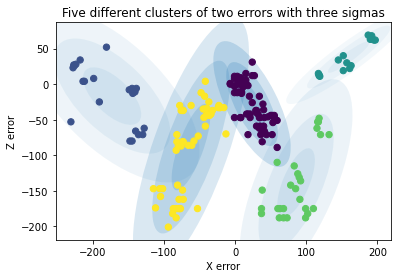

In [89]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel("X error")
ax.set_ylabel("Z error")
ax.set_title("Five different clusters of two errors with three sigmas")
        
gmm = GaussianMixture(n_components=5, random_state=42)
plot_gmm(gmm, x_and_z_errors, ax)
plt.show()

This clustering of the two different errors against each other does not seem to be very useful in estimating the distribution of the position of an object based on the observed value, as those data points are not as well correlated as the "error vs ground truth" as shown below:

The following is a cluster fitted to X error vs X true.
In my opinion, this provides a lot of value, as it characterizes how the error is linear in nature and it also shows the distribution of the error.

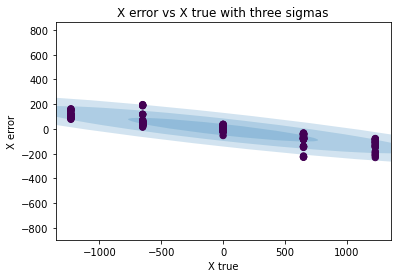

In [41]:
x_true_and_x_error = get_columns(data, [1, 4])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel("X true")
ax.set_ylabel("X error")
ax.set_title("X error vs X true with three sigmas")
        
gmm = GaussianMixture(n_components=1, random_state=1)
plot_gmm(gmm, x_true_and_x_error, ax)
plt.show()

Now, a distribution of Z error vs Z true, which again characterizes the noise pretty well.
This could actually be described using more than one cluster, for the sake of later getting more accurate samples from the distribution (density estimation). For this reason, a graph with three clusters is also shown below.

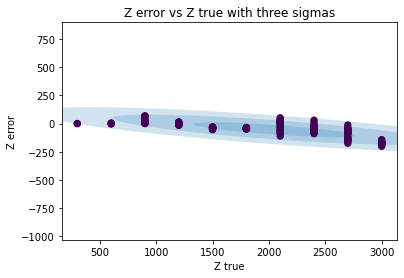

In [51]:
z_true_and_z_error = get_columns(data, [3, 6])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Z true")
ax.set_ylabel("Z error")
ax.set_title("Z error vs Z true with three sigmas")
        
gmm = GaussianMixture(n_components=1, random_state=1)
plot_gmm(gmm, z_true_and_z_error, ax)
plt.show()

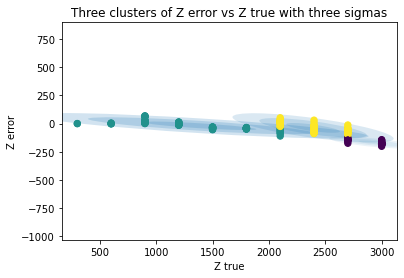

In [97]:
z_true_and_z_error = get_columns(data, [3, 6])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Z true")
ax.set_ylabel("Z error")
ax.set_title("Three clusters of Z error vs Z true with three sigmas")
        
gmm = GaussianMixture(n_components=3, random_state=3)
plot_gmm(gmm, z_true_and_z_error, ax)
plt.show()

In order to illustrate the usefulness of the GMM, samples are drawn and graphed from the previous three cluster fit.

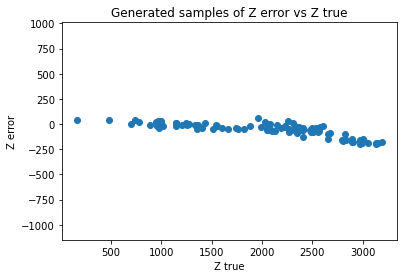

In [98]:
z_true_and_z_error_new, labels = gmm.sample(100)
ax = plt.gca()
ax.set_xlabel("Z true")
ax.set_ylabel("Z error")
ax.set_title("Generated samples of Z error vs Z true")
ax.scatter(z_true_and_z_error_new[:, 0], z_true_and_z_error_new[:, 1])
ax.axis("equal")
plt.show()

Also, by adding the noise to the ground truth, realistic samples of Z measured can be created (Z measured = Z true + Z error).

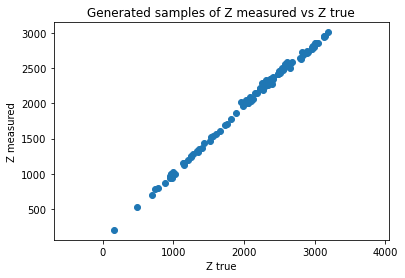

In [99]:
z_measured = z_true_and_z_error_new[:, 0] + z_true_and_z_error_new[:, 1]
ax = plt.gca()
ax.axis("equal")
ax.set_xlabel("Z true")
ax.set_ylabel("Z measured")
ax.set_title("Generated samples of Z measured vs Z true")
ax.scatter(z_true_and_z_error_new[:, 0], z_measured)
plt.show()